In [19]:
# 3a Parsing and k-mer generation
from Bio import SeqIO

K = 15
record = next(r for r in SeqIO.parse("data/human_g1k_v37.fasta", "fasta")
              if r.id == "1")

seq = str(record.seq).upper()
n = len(seq)

# Count Ns in the first window
valid = 0
if n >= K:
    N_in = seq[:K].count("N")
    if N_in <= 2:
        valid += 1

    # Slide one base at a time; update N count in O(1)
    for i in range(1, n - K + 1):
        if seq[i-1] == "N": N_in -= 1
        if seq[i+K-1] == "N": N_in += 1
        if N_in <= 2:
            valid += 1

print("Chromosome 1 length:", n)
print(f"All overlapping {K}-mers:", max(0, n - K + 1))
print("Valid 15-mers (≤2 Ns):", valid)


Chromosome 1 length: 249250621
All overlapping 15-mers: 249250607
Valid 15-mers (≤2 Ns): 225280241


In [ ]:
# 3b Implementing a hash family
import numpy as np
import random

k = 15
M = np.uint64((1 << 61) - 1)   

LUT = np.zeros(256, dtype=np.uint8)
LUT[ord('A')] = 1
LUT[ord('C')] = 2
LUT[ord('G')] = 3
LUT[ord('T')] = 4
LUT[ord('N')] = 5
LUT[ord('X')] = 6

seq_bytes = np.frombuffer(seq.encode('ascii'), dtype=np.uint8)
enc_seq   = LUT[seq_bytes]  
assert enc_seq.size == n, "length mismatch"

t = 100  
random.seed(42)
bases_list, seen = [], set()
while len(bases_list) < t:
    a = random.randrange(1, int(M), 2)  # odd
    if a not in seen:
        seen.add(a)
        bases_list.append(a)

bases = np.array(bases_list, dtype=np.uint64)          
a_km1 = np.remainder(np.power(bases, k-1, dtype=np.uint64), M)

# Initialize rolling hash for the first window (vectorized over hashes)
curr = np.zeros(t, dtype=np.uint64)
w0 = enc_seq[:k].astype(np.uint64)
for c in w0:                     
    curr = (curr * bases + c) % M

# Track per-hash minima over valid windows (≤2 Ns)
mins = np.full(t, M, dtype=np.uint64)
N_in = int(np.count_nonzero(enc_seq[:k] == 5))  # only 'N' (code 5) counts
if N_in <= 2:
    np.minimum(mins, curr, out=mins)

# Slide across chr1 (scalar over positions; vector over hashes
# rolling update: h' = a * (h - left*a^(k-1)) + right (mod M)
for i in range(1, n - k + 1):
    left  = enc_seq[i-1]
    right = enc_seq[i+k-1]

    if left == 5:  N_in -= 1
    if right == 5: N_in += 1

    left_term = (np.uint64(left) * a_km1) % M
    curr = (bases * ((curr - left_term) % M) + np.uint64(right)) % M

    if N_in <= 2:
        np.minimum(mins, curr, out=mins)

# print a few minima
for j in range(min(3, t)):
    print(f"[hash {j+1}] base a={int(bases[j])}  min-hash={int(mins[j])}")

[hash 1] base a=256711978891014971  min-hash=13079539165
[hash 2] base a=1709899039929939363  min-hash=2156202568
[hash 3] base a=564682176223814831  min-hash=5052401618


In [39]:
# 3c Estimating distinct counts from min-hashes
from statistics import mean

t_list = [1, 2, 5, 10, 100]   
t_list = [t for t in t_list if t <= len(mins)]

def estimate_distinct(mins, M, t):
    """Return D_hat using the mean of the first t normalized minima."""
    u = [m / M for m in mins[:t]]
    mu = mean(u)
    return float('inf') if mu == 0 else (1.0 / mu) - 1.0

for t in t_list:
    D_hat = estimate_distinct(mins, M, t)
    print(f"t={t:>4d}  mean(min/M)={mean([m/M for m in mins[:t]]):.6e}  "
          f"estimate≈{int(round(D_hat)):,}")

t=   1  mean(min/M)=5.672346e-09  estimate≈176,293,902
t=   2  mean(min/M)=3.303725e-09  estimate≈302,688,644
t=   5  mean(min/M)=2.849762e-09  estimate≈350,906,525
t=  10  mean(min/M)=3.327625e-09  estimate≈300,514,665
t= 100  mean(min/M)=3.855155e-09  estimate≈259,392,924


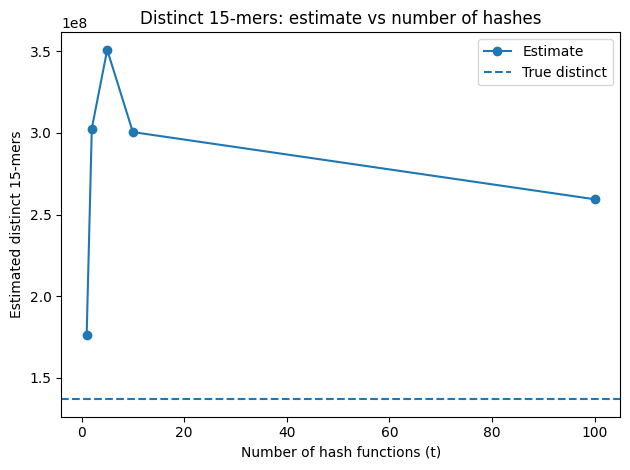

In [40]:
# 3d. Evaluation and analysis
import matplotlib.pyplot as plt

TRUE_DISTINCT = 136904114 
results = [(t, estimate_distinct(mins, M, t)) for t in t_list]

plt.figure()
plt.plot([t for t,_ in results],
         [est for _,est in results],
         marker='o', label='Estimate')
plt.axhline(TRUE_DISTINCT, linestyle='--', label='True distinct')
plt.xlabel('Number of hash functions (t)')
plt.ylabel('Estimated distinct 15-mers')
plt.title('Distinct 15-mers: estimate vs number of hashes')
plt.legend()
plt.tight_layout()
plt.savefig('plots/estimates_3d.png', dpi=150)